In [2]:
# Code modified from https://github.com/nickbiso/Keras-Class-Activation-Map/blob/master/Class%20Activation%20Map(CAM).ipynb

def cam(img_path):

    import cv2
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd 
    import tensorflow.keras
    from tensorflow.keras import backend as K
    from tensorflow.keras.applications.vgg16 import VGG16
    from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input
    from tensorflow.keras.preprocessing import image
    %matplotlib inline
    K.clear_session()    
    
    model = VGG16(weights='imagenet')
    img=mpimg.imread(img_path)
    plt.imshow(img)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
    print("The predicted classes are:")
    print(predictions)
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = '/home/jpace/cv_class/images/output.jpeg'
    cv2.imwrite(output, superimposed_img)
    img=mpimg.imread(output)
    plt.imshow(img)
    plt.axis('off')
    plt.title(predictions.loc[0,'category'].upper())
    return None

The predicted classes are:
            category  probability
0        tiger_shark     0.657342
1  great_white_shark     0.336076
2         hammerhead     0.006074


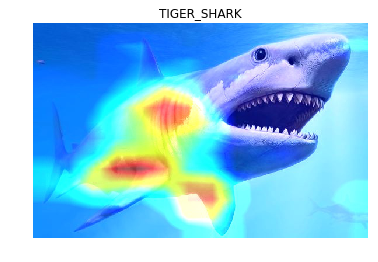

In [3]:
cam('/home/jpace/cv_class/images/Single_Shark.JPG')
#cam('/home/jpace/cv_class/images/Person.JPG')
#cam('/home/jpace/cv_class/images/House.JPG')
#cam('/home/jpace/cv_class/images/Cat.JPG')